# House M.D.

https://en.wikipedia.org/wiki/House_%28TV_series%29

Transcript data: http://clinic-duty.livejournal.com

Work in progress

In [1]:
%pylab inline

import os
import time
import re

import string
from collections import defaultdict
from operator import itemgetter

from bs4 import BeautifulSoup
from urllib.request import urlopen

import textblob
from textblob import TextBlob

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = '/home/laurie/projects/house_md/data/'
episode_index_url = 'http://clinic-duty.livejournal.com/tag/episode%20index'

## Raw html pages

In [3]:
# a few functions to retrieve web pages from disk or online

def get_page_from_disk(path):
    if os.path.exists(path):
        with open(path) as f:
            return f.read()
    else:
        return None

def get_page_online(url, path=None, sleep_sec=None):  
    html = urlopen(url).read().decode('utf-8')
    if path is not None:
        with open(path, 'w') as f:
            f.write(html)
    if sleep_sec is not None:
        time.sleep(sleep_sec)
    return html

def get_page(url, path, sleep_sec=None):
    return get_page_from_disk(path) or get_page_online(url, path, sleep_sec)

In [4]:
class Scraper:
    """ Gets the html page of the episode transcripts """
    
    def __init__(self, data_dir, episode_index_url):
        self.data_dir = data_dir
        self.episode_index_url = episode_index_url
        self.url_map = self.get_url_map(episode_index_url)
        
    def get_url_map(self, episode_index_url):
        
        def is_episode_code(tag):
            # codes are like: '3.06', '5.14'
            p = re.compile('\d\.\d\d')
            return tag.name == 'b' and tag.string is not None and p.match(tag.string) is not None

        path = os.path.join(self.data_dir, 'episode_index.html')
        index_html = get_page(episode_index_url, path)
        soup = BeautifulSoup(index_html, 'html.parser')
        divs = soup.find_all(attrs={"class": "entryText s2-entrytext"})
        if len(divs) != 1:
            raise ValueError('Error: found {} objects matching the class')
        div = divs[0]
        episode_code_tags = div.find_all(is_episode_code)
        
        urls = defaultdict(dict)
        for tag in episode_code_tags:
            season_str, episode_str = tag.string.split('.')
            season = int(season_str)
            episode = int(episode_str)
            episode_link = tag.next_sibling.next_sibling.attrs['href']
            season_links = urls[season]
            assert(episode not in season_links)
            season_links[episode] = episode_link
        return urls
        
    def get_episode(self, season, episode, url=None, sleep_sec=None):
        filename = '{}.{}.html'.format(season, episode)
        path = os.path.join(self.data_dir, filename)
        url = url or self.url_map[season][episode]
        return get_page(url, path, sleep_sec)
    
    def get_all_episodes(self, sleep_sec=1):
        html_pages = defaultdict(dict)
        for season, episodes in self.url_map.items():
            print('{}...'.format(season), end=' ')
            for episode, url in episodes.items():
                html_pages[season][episode] = self.get_episode(season, episode, url, sleep_sec)
        return html_pages
                

In [5]:
scraper = Scraper(data_dir, episode_index_url)
scraper.get_episode(2, 3)[:100]

'<!DOCTYPE html\n         PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n            "http://www.w3.o'

In [6]:
all_raw_episodes = scraper.get_all_episodes()

1... 2... 3... 4... 5... 6... 7... 8... 

## Extract and parse transcripts from html 

In [7]:
def split_line(text):
    comment_pattern = re.compile('\[([^\[\]:]*)(?=\]|$|:)')
    speech_pattern = re.compile('(?:\]|^|:)([^\[\]:$]*)(?=\[|$|:)')
    comments = comment_pattern.findall(text)
    speech = speech_pattern.findall(text)
    speech = list(filter(lambda s: len(s)>0, speech))
    if len(speech) >= 1:
        speaker = speech[0]
        speech = speech[1:]
    else:
        speaker = None
    return speaker, speech, comments

In [8]:
# TODO: proper testing

split_line_tests = [
    ('', (None, [], [])),
    ('Bob: Hello!', ('Bob', [' Hello!'], [])),
    ('xxx:aaa[bbb]ccc[ddd]eee[fff]ggg', ('xxx', ['aaa', 'ccc', 'eee', 'ggg'], ['bbb', 'ddd', 'fff'])),
    ('Bob:Hello![aaa]', ('Bob', ['Hello!'], ['aaa'])),
    ('xx:[aa]bb[cc]', ('xx', ['bb'], ['aa', 'cc'])),
    ('xx:aa[bb', ('xx', ['aa'], ['bb'])),
    ('xx:aa[bb][cc]dd', ('xx', ['aa', 'dd'], ['bb', 'cc'])),
]

for text, (expected_speaker, expected_spoken_parts, expected_comments_parts) in split_line_tests:
    speacker, s, c = split_line(text)
    if speacker != expected_speaker or s != expected_spoken_parts or c != expected_comments_parts:
        print('\n'.join(['text: "{}"'.format(text),
                         'expected speaker: {}, got: {}'.format(expected_speaker, speacker),
                         'expected spoken parts: {}, got: {}'.format(expected_spoken_parts, s),
                         'expected comments parts: {}, got: {}'.format(expected_comments_parts,c),
                         ''
        ]))

In [9]:
class Line:
        
    def __init__(self, line_number, line_str):
        self.num = line_number
        speaker, spoken_parts, comment_parts = split_line(line_str)
        self.speaker = None if speaker is None else speaker.strip().lower()
        self.spoken_parts = list(filter(lambda s: len(s)>0, map(lambda s: s.strip(), spoken_parts)))
        self.comment_parts = list(filter(lambda s: len(s)>0, map(lambda s: s.strip(), comment_parts)))
            
    def __repr__(self):
        return 'Line({}, {}, {}, {})'.format(self.num, self.speaker, self.spoken_parts, self.comment_parts)
            
class Transcript:
    
    def __init__(self, season, episode, html):
        self.season = season
        self.episode = episode
        
        soup = BeautifulSoup(html, 'html.parser')
        
        # get the html div that contains the transcript
        divs = soup.find_all(attrs={"class": "entryText s2-entrytext"})
        if len(divs) != 1:
            raise ValueError('Error: found {} objects matching the class'.format(len(divs)))
        div = divs[0]
        
        transcript = list(div.strings)
        
        # find the disclaimer. Actual transcript starts just after.
        found_disclaimer = False
        for disclaimer_line, line in enumerate(transcript):
            if line.lstrip().startswith('DISCLAIMER: '):
                found_disclaimer = True
                break
        if not found_disclaimer:
            raise ValueError('Error: could not find the disclaimer. Season {}, episode {}.'.format(season, episode))
        self.transcript = transcript[disclaimer_line+1:]  # should not be used. Here for debug
        
        self.lines = [Line(idx, line) for idx, line in enumerate(self.transcript)]
                
    def get_comment_lines(self):
        """ lines with only comments, no speech """
        return filter(lambda line: not line.spoken_parts, self.lines)
    
    def get_dialogue_lines(self):
        return filter(lambda line: line.spoken_parts, self.lines)
    
    def get_all_comments(self):
        for line in self.lines:
            yield from line.comment_parts
            
    def get_dialogue_as_one_string(self):
        texts = []
        for line in self.get_dialogue_lines():
            texts.append('  '.join(line.spoken_parts))
        return '\n'.join(texts)
  
    def get_speakers(self):
        for line in self.lines:
            speaker = line.speaker
            if speaker is not None:
                yield speaker

In [10]:
script1_3 = Transcript(1, 3, all_raw_episodes[1][3])

In [11]:
script1_3.transcript[:3]

['[Cut into an older looking building and then into a room with a boy sitting and talking on the telephone without a shirt on.]',
 'Brandon: I didn’t sleep well last night, and I woke up with a scratchy throat. I just don’t feel so good. [Pause] Uh, cough, [clears his throat] Yeah, I’m, I’m, a bit of an upset stomach too, and I think I’m running a fever, I’m just worried I might be contagious. [Coughs] Inventory, tomorrow, yeah I’m sure I’ll be feeling better by then. [Pause] Thanks, Mr. Nobby.',
 '[Turns off the phone and lays back, we can now see that there is a young girl in bed with him.]']

In [12]:
list(script1_3.get_speakers())[:5]

['brandon', 'mindy', 'brandon', 'mindy', 'brandon']

In [13]:
script1_3.transcript[:3]

['[Cut into an older looking building and then into a room with a boy sitting and talking on the telephone without a shirt on.]',
 'Brandon: I didn’t sleep well last night, and I woke up with a scratchy throat. I just don’t feel so good. [Pause] Uh, cough, [clears his throat] Yeah, I’m, I’m, a bit of an upset stomach too, and I think I’m running a fever, I’m just worried I might be contagious. [Coughs] Inventory, tomorrow, yeah I’m sure I’ll be feeling better by then. [Pause] Thanks, Mr. Nobby.',
 '[Turns off the phone and lays back, we can now see that there is a young girl in bed with him.]']

In [14]:
list(script1_3.get_comment_lines())[:3]

[Line(0, None, [], ['Cut into an older looking building and then into a room with a boy sitting and talking on the telephone without a shirt on.']),
 Line(2, None, [], ['Turns off the phone and lays back, we can now see that there is a young girl in bed with him.']),
 Line(10, both, [], ['Laugh'])]

In [15]:
list(script1_3.get_dialogue_lines())[:3]

[Line(1, brandon, ['I didn’t sleep well last night, and I woke up with a scratchy throat. I just don’t feel so good.', 'Uh, cough,', 'Yeah, I’m, I’m, a bit of an upset stomach too, and I think I’m running a fever, I’m just worried I might be contagious.', 'Inventory, tomorrow, yeah I’m sure I’ll be feeling better by then.', 'Thanks, Mr. Nobby.'], ['Pause', 'clears his throat', 'Coughs', 'Pause']),
 Line(3, mindy, ['I cannot believe you just did that.'], []),
 Line(4, brandon, ['I really do have a cough.'], [])]

In [16]:
list(script1_3.get_all_comments())[:5]

['Cut into an older looking building and then into a room with a boy sitting and talking on the telephone without a shirt on.',
 'Pause',
 'clears his throat',
 'Coughs',
 'Pause']

In [17]:
all_transcripts = {}
for season, episode_html_mapping in all_raw_episodes.items():
    episode_transcript_mapping = {}
    for episode, html in episode_html_mapping.items():
        episode_transcript_mapping[episode] = Transcript(season, episode, html)
    all_transcripts[season] = episode_transcript_mapping

## No spoiler!

I haven't seen all the episodes yet :)

In [18]:
transcripts = {season: all_transcripts[season] for season in (1, 2, 3)}

In [19]:
all_episode_numbers = [(season_num, episode_num) for season_num, season in transcripts.items() for episode_num in season]

In [20]:
'Looking at {} episodes over {} seasons'.format(len(all_episode_numbers), len(transcripts))

'Looking at 70 episodes over 3 seasons'

## Check data a bit

In [21]:
speakers = defaultdict(int)
for season in transcripts.values():
    for episode in season.values():
        for dialogue in episode.get_dialogue_lines():
            speakers[dialogue.speaker] += 1
            
sorted([(speaker, line_count) for speaker, line_count in speakers.items()], key=itemgetter(1), reverse=True)[:10]

[('house', 9915),
 ('foreman', 3832),
 ('cameron', 3347),
 ('chase', 2808),
 ('wilson', 2086),
 ('cuddy', 1812),
 ('stacy', 454),
 ('dad', 186),
 ('mom', 153),
 ('vogler', 119)]

In [22]:
# for season_num, season in transcripts.items():
#     print('\n\nSEASON {}'.format(season_num))
#     for episode_num, transcript in season.items():
#         print('\nepisode {}'.format(episode_num))
#         speakers = set(transcript.get_speakers())
#         print('\n'.join(speakers))
#         print('')
#         print('\n\n'.join(transcript.transcript))

## Build characters

In [23]:
class Character:
    
    def __init__(self, lines):
        self.lines = lines
        self.num_lines = len(lines)
        
        lines_by_episode = defaultdict(lambda: defaultdict(list))
        for season_num, episode_num, line in lines:
            lines_by_episode[season_num][episode_num].append(line)
        self.lines_by_episode = lines_by_episode
        
    def get_text_as_one_string(self):
        texts = []
        for _, _, line in self.lines:
            texts.append('  '.join(line.spoken_parts))
        return '\n'.join(texts)

In [24]:
speaker_lines = defaultdict(list)
for season_num, season in transcripts.items():
    for episode_num, transcript in season.items():
        for line in transcript.get_dialogue_lines():
            speaker_lines[line.speaker].append((season_num, episode_num, line))

In [25]:
all_characters = {}
for speaker, lines in speaker_lines.items():
    all_characters[speaker] = Character(lines)

In [26]:
all_characters['house'].lines_by_episode[1][1][:10]

[Line(40, house, ['See that? They all assume I’m a patient because of this cane.'], []),
 Line(42, house, ['I don’t want them to think I’m a doctor.'], []),
 Line(44, house, ['People don’t want a sick doctor.'], []),
 Line(46, house, ['The one who can’t talk, I liked that part.'], []),
 Line(48, house, ['And your cousin doesn’t like the diagnosis. I wouldn’t either. Brain tumor, she’s gonna die, boring.'], []),
 Line(50, house, ['You’re the oncologist; I’m just a lowly infectious disease guy.'], []),
 Line(52, house, ['She’s 29. Whatever she’s got is highly unlikely.'], []),
 Line(54, house, ['That’s an HMO lab; you might as well have sent it to a high school kid with a chemistry set.'], []),
 Line(56, house, ['I thought your uncle died of cancer.'], []),
 Line(58, house, ['That you know of.'], [])]

## Play!

In [27]:
main_characters = ['house', 'foreman', 'cameron', 'chase', 'wilson', 'cuddy', 'stacy']

### "You're miserable"

In [28]:
def frequency_of_phrase(phrase, characters):
    for c_name in characters:
        c = all_characters[c_name]
        text = c.get_text_as_one_string()
        num_occ = text.lower().count(phrase)
        print('{} said "{}" {} times'.format(c_name, phrase, num_occ))

In [29]:
frequency_of_phrase('miserable', main_characters)

house said "miserable" 20 times
foreman said "miserable" 7 times
cameron said "miserable" 2 times
chase said "miserable" 2 times
wilson said "miserable" 18 times
cuddy said "miserable" 7 times
stacy said "miserable" 0 times


In [30]:
frequency_of_phrase('screw up', main_characters)  # TODO: regex: screwed up

house said "screw up" 17 times
foreman said "screw up" 1 times
cameron said "screw up" 1 times
chase said "screw up" 8 times
wilson said "screw up" 1 times
cuddy said "screw up" 2 times
stacy said "screw up" 3 times


## Number of lines per character per episode

In [31]:
num_lines = {character: [] for character in main_characters}
xlabels = []
for season_num, episode_num in all_episode_numbers:
    xlabels.append('s{}e{}'.format(season_num, episode_num))
    for character in main_characters:
        lines = all_characters[character].lines_by_episode[season_num][episode_num]
        num_lines[character].append(len(lines))

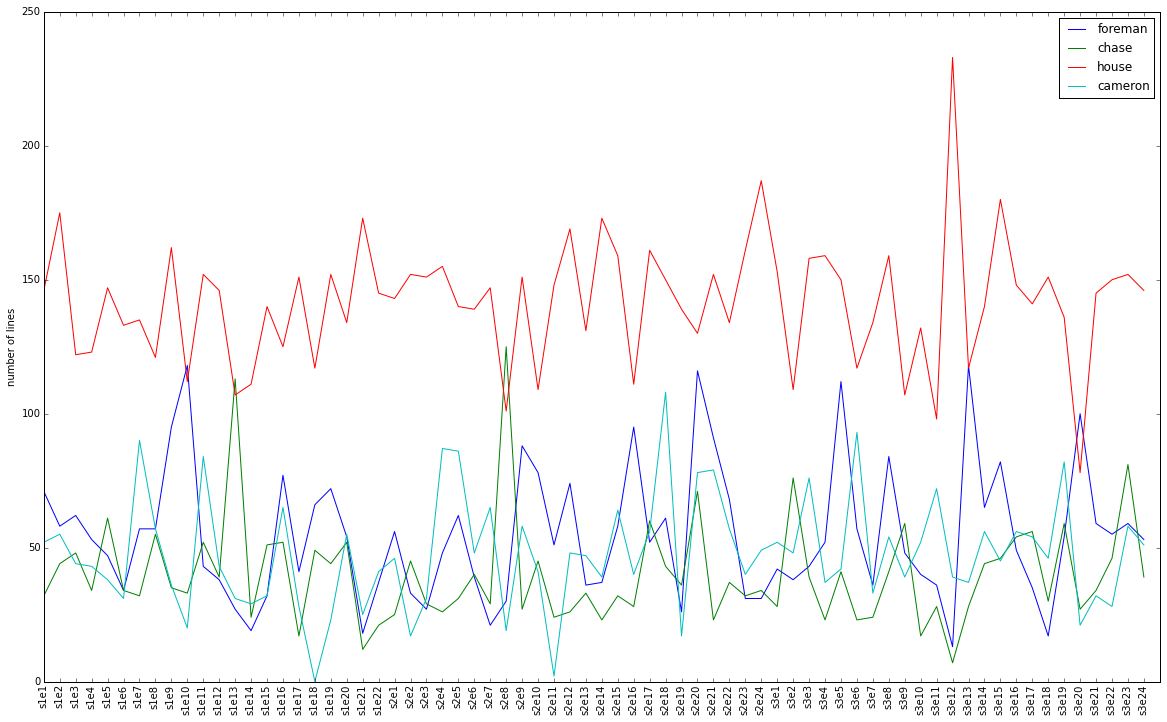

In [32]:
# TODO: normalise by number of lines in the episode?

plt.figure(figsize=(20,12))
for character, nlines in num_lines.items():
    #if character in ('house', 'cuddy', 'wilson', 'stacy'):
    if character in ('house', 'cameron', 'chase', 'foreman'):
        plt.plot(nlines, label=character)
plt.legend(loc='best')
plt.xticks(range(len(all_episode_numbers)), xlabels, rotation='vertical')
plt.ylabel('number of lines')
plt.show()

In [33]:
# What are the peaks?
print('house, high')
print(list(filter(lambda ep_n: ep_n[1] >= 200, list(zip(all_episode_numbers, num_lines['house'])))))
print('house, low')
print(list(filter(lambda ep_n: ep_n[1] <= 100, list(zip(all_episode_numbers, num_lines['house'])))))
print('chase, high')
print(list(filter(lambda ep_n: ep_n[1] >= 100, list(zip(all_episode_numbers, num_lines['chase'])))))
print('chase, low')
print(list(filter(lambda ep_n: ep_n[1] <= 10, list(zip(all_episode_numbers, num_lines['chase'])))))

house, high
[((3, 12), 233)]
house, low
[((3, 11), 98), ((3, 20), 78)]
chase, high
[((1, 13), 113), ((2, 8), 125)]
chase, low
[((3, 12), 7)]


In [34]:
# TODO: look at the characters one after the other to see the variations

### Evolution of the sentiment in each episode

Look only at the spoken parts because some transcript don't have comments

#### First, look at 1 episode

In [35]:
transcript = all_transcripts[2][5]

In [36]:
sentence = ' '.join(list(transcript.get_dialogue_lines())[75].spoken_parts)
print(sentence)
TextBlob(sentence).sentiment

Well this, this is perfect.


Sentiment(polarity=1.0, subjectivity=1.0)

In [37]:
text = transcript.get_dialogue_as_one_string()

In [38]:
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=0.06665244873231808, subjectivity=0.49328373724454494)

In [39]:
tokens = blob.tokens
words = blob.words  # no punctuation
sentences = blob.sentences

In [40]:
len(tokens), tokens[20:30]

(6997,
 WordList(['fact', 'that', 'I', 'actually', 'graduated', '.', 'I', 'always', 'knew', 'you']))

In [41]:
len(words), words[20:30]

(5933,
 WordList(['I', 'actually', 'graduated', 'I', 'always', 'knew', 'you', "'d", 'be', 'able']))

In [42]:
len(sentences), sentences[20:25]

(735,
 [Sentence("What?"),
  Sentence("Yeah right, you shocked me."),
  Sentence("With what?"),
  Sentence("I got nothing."),
  Sentence("Yo dude, check it out.")])

In [43]:
words[:200]

WordList(['I', 'ought', 'to', 'have', 'this', 'framed', 'my', 'last', 'bill', 'from', 'Princeton', 'And', 'I', 'thought', 'we', 'were', 'celebrating', 'the', 'fact', 'that', 'I', 'actually', 'graduated', 'I', 'always', 'knew', 'you', "'d", 'be', 'able', 'to', 'graduate', 'what', 'I', 'didn’t', 'know', 'was', 'whether', 'I', 'would', 'be', 'able', 'to', 'pay', 'for', 'it', 'Your', 'mom', 'uh', 'she’d', 'be', 'so', 'proud', 'of', 'you', 'You', 'always', 'say', 'that', 'I’m', 'so', 'proud', 'of', 'you', 'Always', 'was', 'Come', 'on', 'dad', 'you', 'going', 'to', 'cry', 'You', 'want', 'to', 'be', 'embarrassed', 'You', 'got', 'it', 'Look', 'uh', 'don’t', 'party', 'too', 'hard', 'tonight', 'your', 'grandmother', 'wants', 'a', 'picture', 'of', 'you', 'getting', 'that', 'sheepskin', 'and', 'it’d', 'be', 'nice', 'if', 'you', 'didn’t', 'look', 'completely', 'hung-over', 'Ooh', 'no', 'don’t', 'worry', 'I’ve', 'had', 'enough', 'alcohol', 'in', 'the', 'past', 'week', 'to', 'last', 'me', 'another', 

In [44]:
def sliding_window(seq, size=10, step=1, merge=False):
    for i in range(0, len(seq)-size+1, step):
        window = seq[i:i+size]
        if merge:
            yield ' '.join(window)
        else:
            yield window
        
print(list(sliding_window(['0', '1', '2', '3', '4', '5', '6'], 3)))
print(list(sliding_window('abcde', 2, merge=True)))
print(list(sliding_window(range(20), 10, step=5)))
print(list(sliding_window(range(20), 2, step=5)))

[['0', '1', '2'], ['1', '2', '3'], ['2', '3', '4'], ['3', '4', '5'], ['4', '5', '6']]
['a b', 'b c', 'c d', 'd e']
[range(0, 10), range(5, 15), range(10, 20)]
[range(0, 2), range(5, 7), range(10, 12), range(15, 17)]


In [45]:
def plot_sentiments(sentiments):
    polarities, subjectivities = zip(*sentiments)
    plt.plot(subjectivities, label='subjectivity')
    plt.plot(polarities, label='polarity')
    plt.legend(loc='best')
    plt.axhline(0, color='black', linestyle='--')
    plt.ylim(-1, 1)
    plt.show()

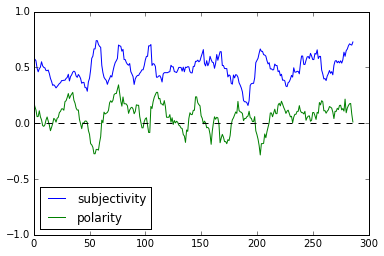

In [46]:
sentiments = [TextBlob(window).sentiment for window in sliding_window(TextBlob(text).words, size=200, step=20, merge=True)]
plot_sentiments(sentiments)

#### Now, look at all episodes at the same time

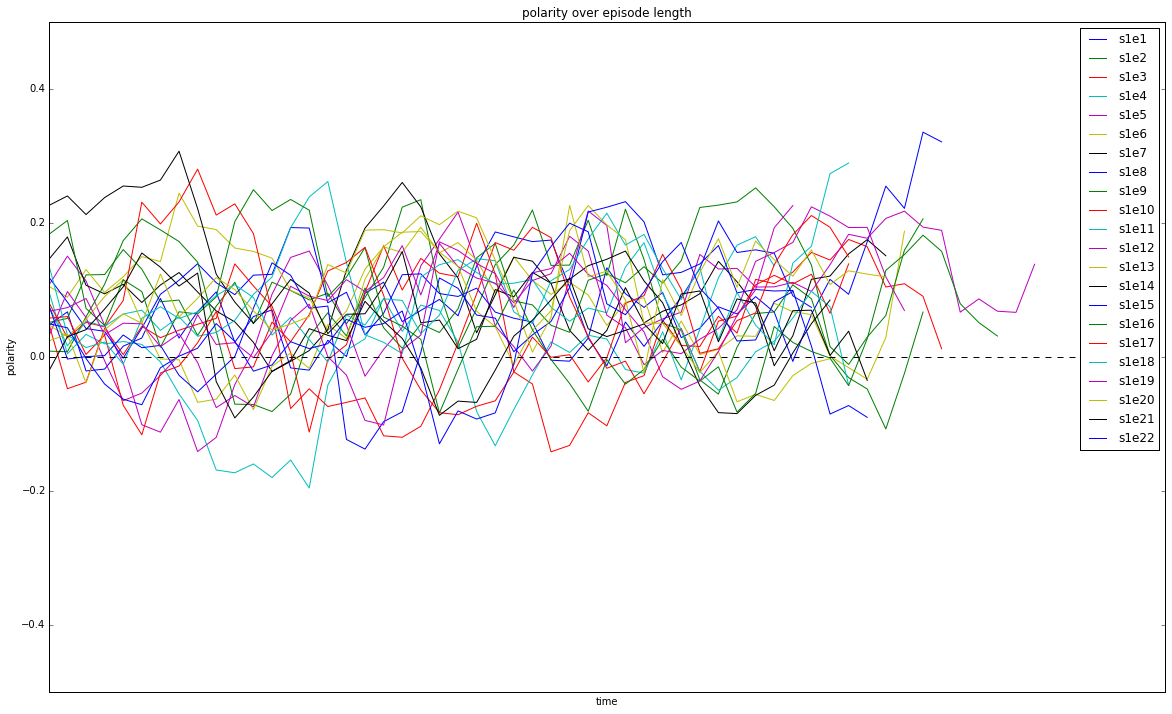

In [47]:
plt.figure(figsize=(20,12))

for episode_num, transcript in all_transcripts[1].items():
    episode_text = transcript.get_dialogue_as_one_string()
    words = TextBlob(episode_text).words
    polarities = [TextBlob(window).sentiment.polarity for window in sliding_window(words, size=400, step=100, merge=True)]
    plt.plot(polarities, label='s1e{}'.format(episode_num))

plt.legend(loc='best')
plt.axhline(0, color='black', linestyle='--')
plt.ylim(-0.5, 0.5)  #plt.ylim(-1, 1)
plt.xlabel('time')
plt.ylabel('polarity')
plt.xticks([], [])
plt.title('polarity over episode length')
plt.show()

#### Focus on 1 episode: 1 curve per character

In [48]:
transcript = all_transcripts[3][5]
sentiments = defaultdict(list)
for line_num, line in enumerate(transcript.get_dialogue_lines()):
    if line.speaker in main_characters:
        speaker = line.speaker
    else:
        speaker = 'other'
    sentiments[speaker].append((line_num, TextBlob(' '.join(line.spoken_parts)).sentiment.polarity))

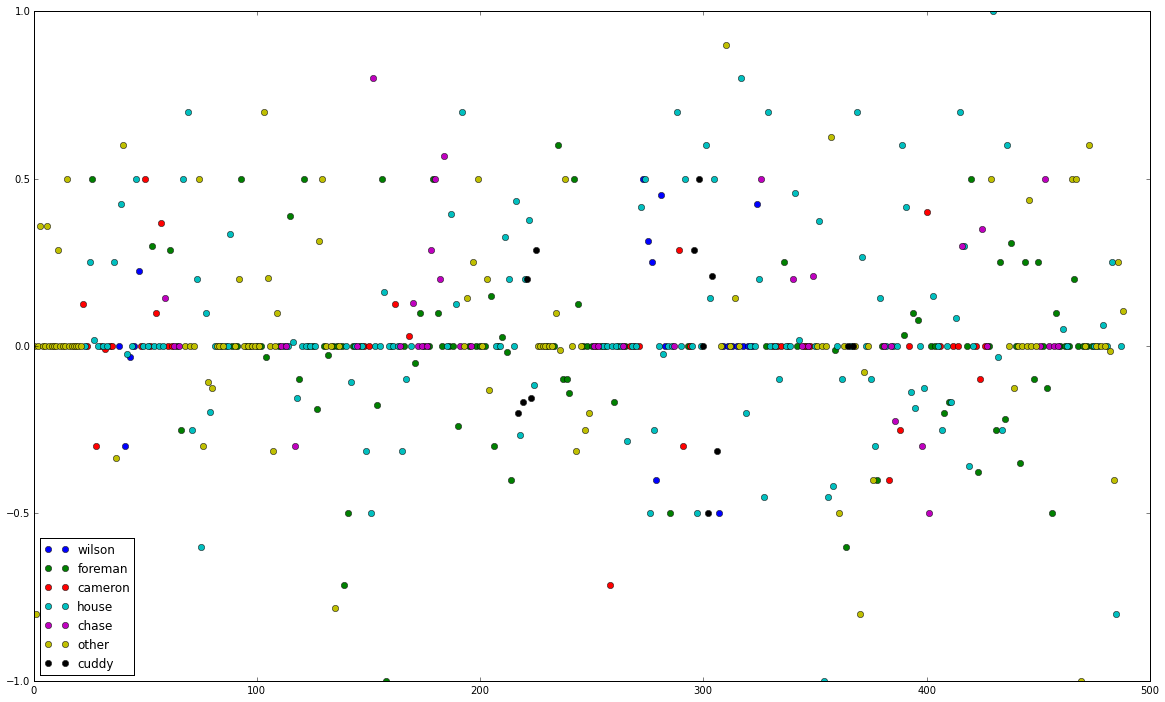

In [49]:
plt.figure(figsize=(20,12))

for character, data in sentiments.items():
    xx, yy = zip(*data)
    plt.plot(xx, yy, 'o', label=character)
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.show()